# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** [Input Nama]
- **Email:** [Input Email]
- **ID Dicoding:** [Input Username]

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import kaggle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from PIL import Image
import random
import zipfile
import pathlib
import tensorflow.lite as tflite
import numpy as np
import ipywidgets as widgets
from io import BytesIO

## Data Preparation

### Data Loading

In [6]:
!kaggle datasets download -d denizkavi1/brain-tumor

Dataset URL: https://www.kaggle.com/datasets/denizkavi1/brain-tumor
License(s): Attribution 4.0 International (CC BY 4.0)
... resuming from 553648128 bytes (179942785 bytes left) ...




 75%|#######5  | 528M/700M [00:00<?, ?B/s]
 76%|#######5  | 529M/700M [00:00<01:19, 2.26MB/s]
 76%|#######5  | 530M/700M [00:00<00:48, 3.64MB/s]
 76%|#######6  | 532M/700M [00:00<00:26, 6.60MB/s]
 76%|#######6  | 534M/700M [00:00<00:19, 9.07MB/s]
 77%|#######6  | 536M/700M [00:01<00:15, 11.1MB/s]
 77%|#######6  | 538M/700M [00:01<00:13, 12.2MB/s]
 77%|#######7  | 540M/700M [00:01<00:12, 13.1MB/s]
 77%|#######7  | 542M/700M [00:01<00:12, 13.7MB/s]
 78%|#######7  | 544M/700M [00:01<00:11, 14.6MB/s]
 78%|#######8  | 546M/700M [00:01<00:11, 14.6MB/s]
 78%|#######8  | 548M/700M [00:01<00:10, 14.7MB/s]
 79%|#######8  | 550M/700M [00:02<00:10, 15.0MB/s]
 79%|#######8  | 552M/700M [00:02<00:09, 15.8MB/s]
 79%|#######9  | 554M/700M [00:02<00:09, 15.8MB/s]
 79%|#######9  | 556M/700M [00:02<00:09, 16.0MB/s]
 80%|#######9  | 558M/700M [00:02<00:09, 16.5MB/s]
 80%|########  | 560M/700M [00:02<00:09, 16.0MB/s]
 80%|########  | 562M/700M [00:02<00:08, 16.7MB/s]
 81%|########  | 564M/700M [00:02<00:0

In [9]:
extract_folder = 'brain-tumor'
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

with zipfile.ZipFile('brain-tumor.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [2]:
data_dir = './brain-tumor'
disease_types = ['1', '2', '3']

for disease in disease_types:
    rice_dir = os.path.join(data_dir, disease)
    print(f"There are {len(os.listdir(rice_dir))} images of {disease.lower()}.")

There are 708 images of 1.
There are 1426 images of 2.
There are 930 images of 3.


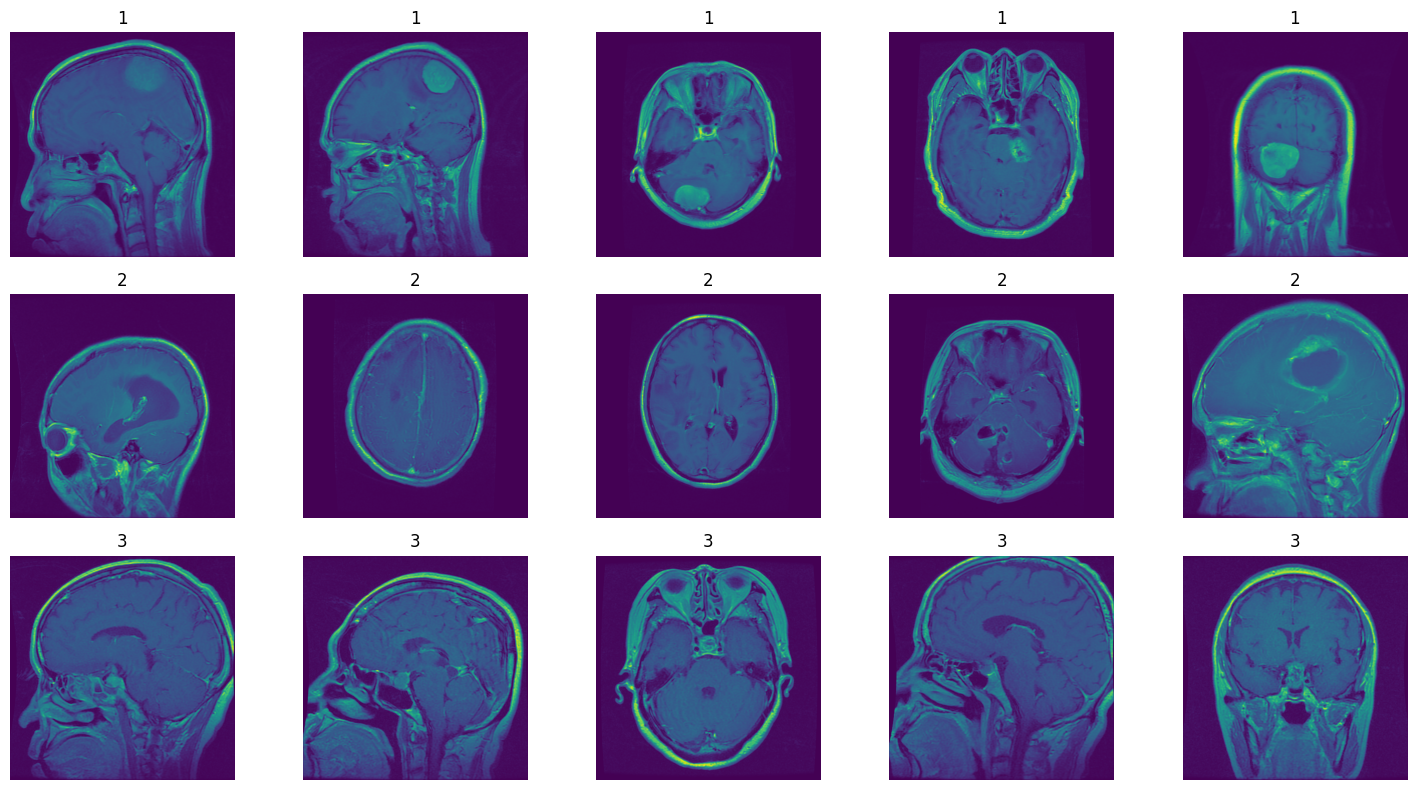

In [3]:
dataset_path = "brain-tumor"

classes = sorted([folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))])
num_rows = 3
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

for i, class_name in enumerate(classes[:num_rows]):
    class_path = os.path.join(dataset_path, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = random.sample(images, min(len(images), num_cols))

    for j, image_name in enumerate(selected_images):
        img_path = os.path.join(class_path, image_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(class_name)
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

In [4]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_files = os.listdir(subdir_path)
            num_images = len(image_files)
            print(f"{subdir}: {num_images}")
            total_images += num_images
            for img_file in image_files:
                img_path = os.path.join(subdir_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        unique_sizes.add(img.size)
                except Exception as e:
                    print(f"Error opening {img_path}: {e}")
            for size in unique_sizes:
                print(f"- {size}")
            print("---------------")
    print(f"\nTotal: {total_images}")
print_images_resolution('brain-tumor')

1: 708
- (512, 512)
---------------
2: 1426
- (512, 512)
---------------
3: 930
- (512, 512)
- (256, 256)
---------------

Total: 3064


### Data Preprocessing

#### Split Dataset

In [15]:
train_dir = "data_split/train/"
val_dir = "data_split/val/"
test_dir = "data_split/test/"

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    images = os.listdir(cls_path)

    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)

    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))

    for img in val_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))

    for img in test_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))

print("✅ Train-Validation-Test split Have Done!")

✅ Train-Validation-Test split Have Done!


In [21]:
train_dir = "data_split/train/"
val_dir = "data_split/val/"
test_dir = "data_split/test/"

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2450 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 307 images belonging to 3 classes.


## Modelling

In [22]:
class EarlyStoppingCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.99:
            self.model.stop_training = True
            print("\nReached 99% Train Accuracy and 99% Validation Accuracy, Model Stop!")

In [23]:
def create_model_cnn():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
    )
    return model

model_cnn = create_model_cnn()
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,666,659 (6.36 MB)

 Trainable params: 1,666,659 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_cnn = model_cnn.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[EarlyStoppingCallbacks()]
)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.9376 - loss: 0.1703 - val_accuracy: 0.9381 - val_loss: 0.2067
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.9635 - loss: 0.0911 - val_accuracy: 0.9283 - val_loss: 0.2092
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - accuracy: 0.9722 - loss: 0.0812 - val_accuracy: 0.9251 - val_loss: 0.2089
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 276ms/step - accuracy: 0.9676 - loss: 0.0892 - val_accuracy: 0.9316 - val_loss: 0.2547
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 296ms/step - accuracy: 0.9655 - loss: 0.0822 - val_accuracy: 0.9121 - val_loss: 0.2688
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - accuracy: 0.9688 - loss: 0.0798 - val_accuracy: 0.9381 - val_loss: 0.2176
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - accuracy: 0.9783 - loss: 0.0551 - val_accuracy: 0.9349 - val_loss: 0.2280
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.9706 - loss: 0.0682 - val_accu

In [29]:
def create_model_mobilenet():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    base_model.trainable = False
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(3, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model_mobilenetv2 = create_model_mobilenet()
model_mobilenetv2.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
history_mobilenet = model_mobilenetv2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[EarlyStoppingCallbacks()]
)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 398ms/step - accuracy: 0.6200 - loss: 0.9434 - val_accuracy: 0.8502 - val_loss: 0.3767
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 379ms/step - accuracy: 0.8265 - loss: 0.4142 - val_accuracy: 0.8730 - val_loss: 0.3032
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 380ms/step - accuracy: 0.8606 - loss: 0.3486 - val_accuracy: 0.8893 - val_loss: 0.2672
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 385ms/step - accuracy: 0.8754 - loss: 0.3200 - val_accuracy: 0.8860 - val_loss: 0.2683
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 385ms/step - accuracy: 0.8839 - loss: 0.2803 - val_accuracy: 0.8958 - val_loss: 0.2580
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 389ms/step - accuracy: 0.8933 - loss: 0.2638 - val_accuracy: 0.8990 - val_loss: 0.2230
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 377ms/step - accuracy: 0.8994 - loss: 0.2430 - val_accuracy: 0.9121 - val_loss: 0.2142
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 389ms/step - accuracy: 0.9031 - loss: 0.2236 - val_accu

In [39]:
def create_model_resnet():
    base_model = tf.keras.applications.ResNet152V2(input_shape=(224,224,3), weights='imagenet', include_top=False)
    base_model.trainable = False
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(3, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model_resnet = create_model_resnet()
model_resnet.summary()

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_16[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 58,594,307 (223.52 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [40]:
history_resnet = model_resnet.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[EarlyStoppingCallbacks()]
)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.6630 - loss: 0.8222 - val_accuracy: 0.8306 - val_loss: 0.4446
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8059 - loss: 0.4746 - val_accuracy: 0.8339 - val_loss: 0.3766
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8217 - loss: 0.4117 - val_accuracy: 0.8860 - val_loss: 0.3343
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8478 - loss: 0.3718 - val_accuracy: 0.8827 - val_loss: 0.2868
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8514 - loss: 0.3422 - val_accuracy: 0.8990 - val_loss: 0.2826
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8733 - loss: 0.3043 - val_accuracy: 0.8762 - val_loss: 0.2824
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8774 - loss: 0.2876 - val_accuracy: 0.8860 - val_loss: 0.3429
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8935 - loss: 0.2581 - val_accuracy: 0.8730 - v

## Evaluasi dan Visualisasi

In [41]:
model_cnn_evaluate = model_cnn.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - accuracy: 0.9542 - loss: 0.2098


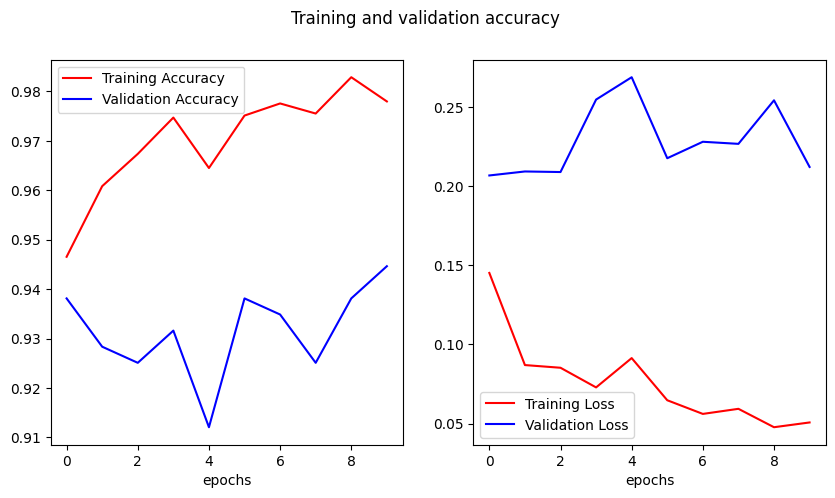

In [42]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [43]:
model_mobilenetv2_evaluate = model_mobilenetv2.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 468ms/step - accuracy: 0.9038 - loss: 0.2591


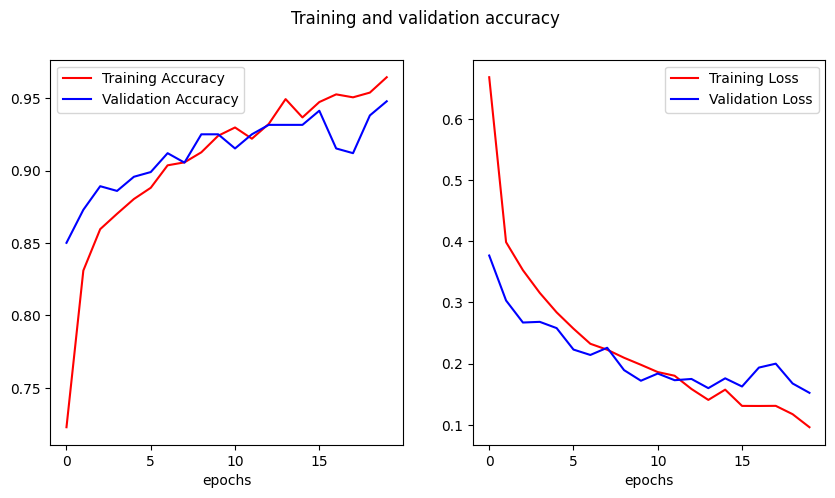

In [44]:
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [45]:
model_resnet_evaluate = model_resnet.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9062 - loss: 0.2852


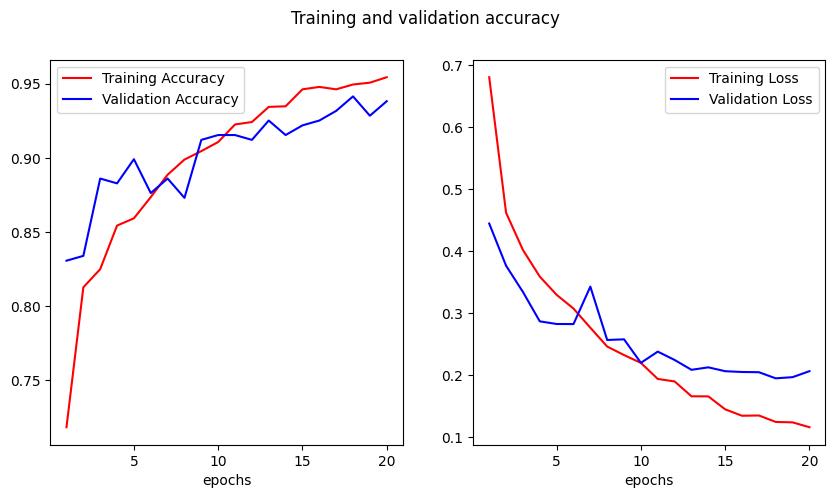

In [50]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

## Konversi Model

In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path("model_cnn.tflite")
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\fikri\AppData\Local\Temp\tmpbj_zl3rt\assets


INFO:tensorflow:Assets written to: C:\Users\fikri\AppData\Local\Temp\tmpbj_zl3rt\assets


Saved artifact at 'C:\Users\fikri\AppData\Local\Temp\tmpbj_zl3rt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1193')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  3237665595344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3237665595152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3237665597648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3237665601104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3237665598032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3237665602640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3237665597072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3237665603408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3237665603024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3237665588240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

6671252

## Inference (Optional)

In [2]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

model_path = "model_cnn.tflite"
interpreter = tflite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

class_labels = ["Meningioma", "Glioma", "Pituitary Tumor"]

def file_predict(filename, file, out):
    image = Image.open(file).convert("RGB")
    image = image.resize((224, 224))
    image = np.array(image, dtype=np.float32) / 255.0
    image = np.expand_dims(image, axis=0)
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])[0]
    predicted_class_index = np.argmax(prediction)
    confidence = np.max(prediction)
    predicted_label = class_labels[predicted_class_index]
    with out:
        print(f"{filename} Classified as: {predicted_label} (Confidence: {confidence:.2f})")

def on_upload_change(change):
    items = change.new
    for item in items:
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)
uploader.observe(on_upload_change, names='value')


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()